# Deterministic neural network for neutron star equation of state

We investigate the regression problem of retrieving the neutron star (NS) equation of state (EOS) from observational data with a deterministic neural network.

We first consider observational data only composed by masses M and radii R. We then explore the case where also the l=2 dimensionless tidal Love number is known.

## Import
Import here useful packages.

In [1]:
import tensorflow as tf
import numpy as np
import statistics
from pandas import read_csv
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import load_model
from model_det import *

2024-04-22 16:16:43.860905: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-22 16:16:43.889797: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-22 16:16:43.889827: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-22 16:16:43.889848: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-22 16:16:43.895739: I tensorflow/core/platform/cpu_feature_g

## M-R observational data
Neural networks for the case were the inputs are only composed of M-R data. We utilise two different neural networks; a classification model to calculate the probability of the low density EOS to either belong to the AP4 or the SLy class, and a regression model to retrieve the value of the vacuum energy shift and the speed of sound parametrization.

### Dataset

Let us upload the dataset, renormalize it, divide it in input/output, and in training set and validation set. 


First, we load the dataset. For the case of 15 observation M-R points, there are 46 columns (from 0 to 45). From 0 to 15 we have the outputs, which describes the specific EOS chosen. From 16 to 45, we have the inputs, that is the mass and radius points. The precise structure is as follow:
- column 0, the low-density EOS, it can either be AP4 or SLy. 
- column 1, the value of cosmological constant (from -(194 MeV)^4 to (194 MeV)^4). 
- column 2-8, the 7 random values of mass density for the QCD speed of sound parametrization.
- column 9-15, the 7 random values of speed of sound for the QCD speed of sound parametrization.
- column 16-30, the 15 values of the masses on the M-R curve.
- column 31-45, the 15 values of the radii on the M-R curve.

We can also choose between different dataset. First of all, we can choose between 15, 20, and 30 observation points from each M-R curve. Doing so, increase the number of columns of the dataset. We can also change the number of 'shifting' repetitions (100, 200, 300). Note that for the case of 15 obs. points, only the 100 and 200 repetition dataset are provided.

In [ ]:
#Choose how many observational points we want (15,20,30) and rep. of shifting (100,200,300)
points = 15 #15 #20 #30
rep = 200 #100 #200 #300

In [ ]:
if points == 15:
    if rep == 100:
        df = read_csv("dataset_15points.csv", header = None)
    elif rep == 200:
        df = read_csv("dataset_15points_larger.csv", header = None)
elif points == 20:
    if rep == 100:
        df = read_csv("dataset_20points.csv", header = None)
    elif rep == 200:
        df = read_csv("dataset_20points_larger.csv", header = None)
    elif rep == 300:
        df = read_csv("dataset_20points_larger300.csv", header = None)
elif points == 30:
    if rep == 100:
        df = read_csv("dataset_30points.csv", header = None)
    elif rep == 200:
        df = read_csv("dataset_30points_larger.csv", header = None)
    elif rep == 300:
        df = read_csv("dataset_30points_larger300.csv", header = None)

We shuffle the dataset. This is important to avoid overfitting in the neural networks.

In [ ]:
df = df.sample(frac=1).reset_index(drop=True)

We split the dataset into inputs (X) and outputs (y). Note that the SLy/AP4 data is saved as a different output as this goes into a different model (classification). For the classification model there are 2 classes, either SLy or AP4.

In [ ]:
if points == 15:
    X, yeos, y = df.iloc[:,16:46].values, df.iloc[:,0].values, df.iloc[:,1:16].values
elif points == 20:
    X, yeos, y = df.iloc[:,16:56].values, df.iloc[:,0].values, df.iloc[:,1:16].values
elif points == 30:
    X, yeos, y = df.iloc[:,16:76].values, df.iloc[:,0].values, df.iloc[:,1:16].values

During the shifting procedure (when the data was generated) some of the lower masses on the M-R curve can become negative. This is clearly an unphysical feature, and we eliminate those observational data that present this anomaly.

In [ ]:
#Eliminate those M-R curves with negative masses and radii
indices = []
for i in range(0,len(X)): #rows
    for j in range(0,len(X[1])): #columns
        if X[i,j] < 0:
            indices.append(i)
            break
X = np.delete(X,indices,axis=0)
yeos = np.delete(yeos,indices,axis=0)
y = np.delete(y,indices,axis=0)

We normalize our outputs, such as as each entry is between (0,1). Note that the speed of sound does not need to be renormalized, since it is already in the interval (0,1).

In [ ]:
#Encode strings to integer (AP4,SLy)->(0,1)
yeos[:] = LabelEncoder().fit_transform(yeos[:])
#Normalize Λ column and ρ to range (0,1)
y[:,0] = (y[:,0] + 194.)/388.
y[:,1] = y[:,1]/y[0,7]
y[:,2] = y[:,2]/y[0,7]
y[:,3] = y[:,3]/y[0,7]
y[:,4] = y[:,4]/y[0,7]
y[:,5] = y[:,5]/y[0,7]
y[:,6] = y[:,6]/y[0,7]
y[:,7] = y[:,7]/y[0,7]

We create the two classes output for the classification model, needed to distinguish between AP4 and SLy.

In [ ]:
yclass = np.empty([len(yeos), 2])
for i in range(0,len(yeos)):
    #first value in array is SLy class, second value is AP4 class
    yclass[i] = [yeos[i], 1- yeos[i]]

In [ ]:
#Ensure all data are floating point values
X = X.astype('float32')
yclas = yclass.astype('float32')
y = y.astype('float32')
print(X.shape, yclass.shape, y.shape)

In [ ]:
#If needed, split into train and test datasets
X_train, X_test, yclass_train, yclass_test, y_train, y_test = train_test_split(X, yclass, y, test_size=0.33)
print(X_train.shape, X_test.shape, yclass_train.shape, yclass_test.shape, y_train.shape, y_test.shape)

In [ ]:
#Determine the number of input features
n_features = X.shape[1]

### Classification neural network

This is the classification analysis. It calculates the probability for the EOS to either be the SLy or the AP4 in the low energy density regime.

#### The model
Several models have been created (and tested) they are stored in the folder as 'modelClass_n{rep}_N{points}_{nodes1}_{nodes2}_{nodes3}.keras'.

In [ ]:
loss_list = []
acc_list = []
val_loss_list = []
val_acc_list = []
last_acc = 0.
n_nodes = 1 #1 #2 #3 #CHOOSE!
nodes1 = 270 #CHOOSE!
nodes2 = 0 #CHOOSE! If not present put 0, to store model/plot correctly 
nodes3 = 0 #CHOOSE! If not present put 0, to store model/plot correctly
activation_hidden = 'relu'
ke_init = 'he_normal'
activation_out = 'sigmoid'
ke_init_out = 'glorot_uniform'


for x in range(20):
    print('Evaluating cycle:',x)
    
    #create model
    model = produce_model_class(n_nodes, nodes1, nodes2, nodes3, activation_hidden,
                              ke_init, activation_out, ke_init_out, n_features)
    # summarize the model
    #model.summary()
    
    #Compile the model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_accuracy'])
    
    #Fit the model
    history = model.fit(X, yclass, epochs=100, batch_size=100, verbose=1, 
                        validation_split = 0.2)
    
    #Store last value of loss, accuracy, validation loss, and validation accuracy
    store_values_class(loss_list, val_loss_list, acc_list, val_acc_list, history)
    
    #Save only best model and plot its learning curves
    if history.history['binary_accuracy'][-1] > last_acc:
        print('Saving model at cycle:', x)
        model.save(f'modelClass_n{rep}_N{points}_{nodes1}_{nodes2}_{nodes3}.keras')
        last_acc = history.history['binary_accuracy'][-1]
        
        #Plot learning curves and save
        plot_learning_curve_class(history, rep, points, nodes1, nodes2, nodes3, 
                                check_k2 = False)
        
        #Plot accuracy and save
        plot_accuracy(history, rep, points, nodes1, nodes2, nodes3, check_k2 = False)
    
acc_mean, acc_stdv = statistics.mean(acc_list), statistics.pstdev(acc_list)    
val_acc_mean, val_acc_stdv = statistics.mean(val_acc_list), statistics.pstdev(val_acc_list)
loss_mean, loss_stdv = statistics.mean(loss_list), statistics.pstdev(loss_list)    
val_loss_mean,val_loss_stdv=statistics.mean(val_loss_list),statistics.pstdev(val_loss_list)

loss_mean,loss_stdv,val_loss_mean,val_loss_stdv,acc_mean,acc_stdv,val_acc_mean,val_acc_stdv

In [ ]:
#Plot the model
plot_model(model, f'modelClass_n{rep}_N{points}_{nodes1}_{nodes2}_{nodes3}.png', 
           show_shapes=True);

### Regression neural network

This is the regression analysis, made for retrieving the cosmological constant value and the speed of sound vs mass density part.

#### The model

Let us create and train our neural network. Several models have been created (and tested) they are stored in the folder as 'modelReg_n{rep}_ N{points}_{nodes}.keras'.

Each model has been tested 20 times, we can evaluate the mean and the standard deviation of the loss (training and validation), we save only the model with the lowest loss for each configuration.

In [ ]:
loss_list = []
val_loss_list = []
last_loss = 1
nodes = 90
activation_hidden = 'relu'
ke_init = 'he_normal'
activation_out = 'sigmoid'
ke_init_out = 'glorot_uniform'

for x in range(20):
    print('Evaluating cycle:',x)
    #create model
    model = produce_model_reg(nodes, activation_hidden, ke_init, activation_out, 
                              ke_init_out, n_features)
    
    #compile model
    model.compile(optimizer='adam', loss='msle')
    
    #Fit the model
    history = model.fit(X, y, epochs=100, batch_size=100, verbose=1, validation_split = 0.2)
    
    #Store last value of loss and validation loss
    store_values_reg(loss_list, val_loss_list, history)
        
    #Save only best model and plot its learning curves
    if history.history['loss'][-1] < last_loss:
        print('Saving model at cycle:', x)
        model.save(f'modelReg_n{rep}_N{points}_{nodes}.keras')
        last_loss = history.history['loss'][-1]
        
        #Plot learning curves and save
        plot_learning_curve_reg(history, rep, points, nodes, check_k2 = False)
    
loss_mean, loss_stdv = statistics.mean(loss_list), statistics.pstdev(loss_list)    
val_loss_mean, val_loss_stdv = statistics.mean(val_loss_list), statistics.pstdev(val_loss_list)
loss_mean, loss_stdv, val_loss_mean, val_loss_stdv 

In [ ]:
#Plot the model
plot_model(model, f'modelReg_n{rep}_N{points}_{nodes}.png', show_shapes=True);

## M-R-k2 observational data

Neural networks for the case were the inputs are composed of M-R-k2 data. We utilise two different neural networks; a classification model to calculate the probability of the low density EOS to either belong to the AP4 or the SLy class, and a regression model to retrieve the value of the vacuum energy shift and the speed of sound parametrization.

### Dataset

Let us upload the dataset, renormalize it, divide it in input/output, and in training set and validation set.

First, we load the dataset. For the case of 15 observation M-R points, there are 61 columns (from 0 to 60). From 0 to 15 we have the outputs, which describes the specific EOS chosen. From 16 to 45, we have the inputs, that is the mass, radius and k2 points. The precise structure is as follow:
- column 0, the low-density EOS, it can either be AP4 or SLy. 
- column 1, the value of cosmological constant (from -(194 MeV)^4 to (194 MeV)^4). 
- column 2-8, the 7 random values of mass density for the QCD speed of sound parametrization.
- column 9-15, the 7 random values of speed of sound for the QCD speed of sound parametrization.
- column 16-30, the 15 values of the masses on the M-R curve.
- column 31-45, the 15 values of the radii on the M-R curve.
- column 46-60, the 15 values of the tidal Love number on the M-k2 curve.

We can also choose between different dataset. First of all, we can choose between 15, 20, and 30 observation points from each M-R curve. Doing so, increase the number of columns of the dataset. We can also change the number of 'shifting' repetitions (100, 200, 300). Note that for the case of 15 obs. points, only the 100 and 200 repetition dataset are provided.

In [ ]:
#Choose how many observational points we want (15,20,30) and rep. of shifting (100,200,300)
points = 15 #15 #20 #30
rep = 200 #100 #200 #300

In [ ]:
if points == 15:
    if rep == 100:
        df = read_csv("datasetk2_15points.csv", header = None)
    elif rep == 200:
        df = read_csv("datasetk2_15points_larger.csv", header = None)
elif points == 20:
    if rep == 100:
        df = read_csv("datasetk2_20points.csv", header = None)
    elif rep == 200:
        df = read_csv("datasetk2_20points_larger.csv", header = None)
    elif rep == 300:
        df = read_csv("datasetk2_20points_larger300.csv", header = None)
elif points == 30:
    if rep == 100:
        df = read_csv("datasetk2_30points.csv", header = None)
    elif rep == 200:
        df = read_csv("datasetk2_30points_larger.csv", header = None)
    elif rep == 300:
        df = read_csv("datasetk2_30points_larger300.csv", header = None)

We shuffle the dataset. This is important to avoid overfitting in the neural networks.

In [ ]:
df = df.sample(frac=1).reset_index(drop=True)

We split the dataset into inputs (X) and outputs (y). Note that the SLy/AP4 data is saved as a different output as this goes into a different model (classification). For the classification model there are 2 classes, either SLy or AP4.

In [ ]:
if points == 15:
    X, yeos, y = df.iloc[:,16:61].values, df.iloc[:,0].values, df.iloc[:,1:16].values
elif points == 20:
    X, yeos, y = df.iloc[:,16:76].values, df.iloc[:,0].values, df.iloc[:,1:16].values
elif points == 30:
    X, yeos, y = df.iloc[:,16:106].values, df.iloc[:,0].values, df.iloc[:,1:16].values

During the shifting procedure (when the data was generated) some of the lower masses on the M-R curve can become negative. This is clearly an unphysical feature, and we eliminate those observational data that present this anomaly.

In [ ]:
#Eliminate those M-R-k2 curves with negative masses and radii
indices = []
for i in range(0,len(X)): #rows
    for j in range(0,len(X[1])-points): #columns
        if X[i,j] < 0:
            indices.append(i)
            break
X = np.delete(X,indices,axis=0)
yeos = np.delete(yeos,indices,axis=0)
y = np.delete(y,indices,axis=0)

We normalize our outputs, such as as each entry is between (0,1). Note that the speed of sound does not need to be renormalized, since it is already in the interval (0,1). We also normalize the k2 values.

In [ ]:
#Encode strings to integer (AP4,SLy)->(0,1)
yeos[:] = LabelEncoder().fit_transform(yeos[:])
#Normalize Λ column and ρ to range (0,1)
y[:,0] = (y[:,0] + 194.)/388.
y[:,1] = y[:,1]/y[0,7]
y[:,2] = y[:,2]/y[0,7]
y[:,3] = y[:,3]/y[0,7]
y[:,4] = y[:,4]/y[0,7]
y[:,5] = y[:,5]/y[0,7]
y[:,6] = y[:,6]/y[0,7]
y[:,7] = y[:,7]/y[0,7]

In [ ]:
if points == 15:
    k2max = X[:,30:45].max()
    k2min = X[:,30:45].min()
    X[:,30:45] = renormalize(X[:,30:45], k2min, k2max)
elif points == 20:
    k2max = X[:,40:60].max()
    k2min = X[:,40:60].min()
    X[:,40:60] = renormalize(X[:,40:60], k2min, k2max)
elif points == 30:#check
    k2max = X[:,60:90].max()
    k2min = X[:,60:90].min()
    X[:,60:90] = renormalize(X[:,60:90], k2min, k2max)

We create the two classes output for the classification model, needed to distinguish between AP4 and SLy.

In [ ]:
yclass = np.empty([len(yeos), 2])
for i in range(0,len(yeos)):
    #first value in array is SLy class, second value is AP4 class
    yclass[i] = [yeos[i], 1- yeos[i]]

In [ ]:
#Ensure all data are floating point values
X = X.astype('float32')
yclass = yclass.astype('float32')
y = y.astype('float32')
print(X.shape, yclass.shape, y.shape)

In [ ]:
#If needed, split into train and test datasets
X_train, X_test, yclass_train, yclass_test, y_train, y_test = train_test_split(X, yclass, y, test_size=0.33)
print(X_train.shape, X_test.shape, yclass_train.shape, yclass_test.shape, y_train.shape, y_test.shape)

In [ ]:
#Determine the number of input features
n_features = X.shape[1]

### Classification neural network

This is the classification analysis. It calculates the probability for the EOS to either be the SLy or the AP4 in the low energy density regime.

#### The model

Several models have been created (and tested) they are stored in the folder as 'modelClassk2_n{rep}_N{points}_{nodes1}_{nodes2}_{nodes3}.keras'.

In [ ]:
loss_list = []
acc_list = []
val_loss_list = []
val_acc_list = []
last_acc = 0.
n_nodes = 3 #1 #2 #3
nodes1 = 270
nodes2 = 90
nodes3 = 90
activation_hidden = 'relu'
ke_init = 'he_normal'
activation_out = 'sigmoid'
ke_init_out = 'glorot_uniform'


for x in range(20):
    print('Evaluating cycle:',x)
    
    #create model
    model = produce_model_class(n_nodes, nodes1, nodes2, nodes3, activation_hidden,
                              ke_init, activation_out, ke_init_out, n_features)
    # summarize the model
    #model.summary()
    
    #Compile the model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_accuracy'])
    
    #Fit the model
    history = model.fit(X, yclass, epochs=100, batch_size=100, verbose=1, 
                        validation_split = 0.2)
    
    #Store last value of loss, accuracy, validation loss, and validation accuracy
    store_values_class(loss_list, val_loss_list, acc_list, val_acc_list, history)
    
    #Save only best model and plot its learning curves
    if history.history['binary_accuracy'][-1] > last_acc:
        print('Saving model at cycle:', x)
        model.save(f'modelClassk2_n{rep}_N{points}_{nodes1}_{nodes2}_{nodes3}.keras')
        last_acc = history.history['binary_accuracy'][-1]
        
        #Plot learning curves and save
        plot_learning_curve_class(history, rep, points, nodes1, nodes2, nodes3, 
                                  check_k2 = True)
        
        #Plot accuracy and save
        plot_accuracy(history, rep, points, nodes1, nodes2, nodes3, check_k2 = True)
    
acc_mean, acc_stdv = statistics.mean(acc_list), statistics.pstdev(acc_list)    
val_acc_mean, val_acc_stdv = statistics.mean(val_acc_list), statistics.pstdev(val_acc_list)
loss_mean, loss_stdv = statistics.mean(loss_list), statistics.pstdev(loss_list)    
val_loss_mean,val_loss_stdv=statistics.mean(val_loss_list),statistics.pstdev(val_loss_list)

loss_mean,loss_stdv,val_loss_mean,val_loss_stdv,acc_mean,acc_stdv,val_acc_mean,val_acc_stdv

In [ ]:
#Plot the model
plot_model(model, f'modelClassk2_n{rep}_N{points}_{nodes1}_{nodes2}_{nodes3}.png', 
           show_shapes=True);

### Regression neural network

This is the regression analysis, made for retrieving the cosmological constant value and the speed of sound vs mass density part.

#### The model

Let us create and train our neural network. Several models have been created (and tested) they are stored in the folder as 'modelRegk2_n{rep}_ N{points}_{nodes}.keras'.

Each model has been tested 20 times, we can evaluate the mean and the standard deviation of the loss (training and validation), we save only the model with the lowest loss for each configuration.

In [ ]:
loss_list = []
val_loss_list = []
last_loss = 1
nodes = 180
activation_hidden = 'relu'
ke_init = 'he_normal'
activation_out = 'sigmoid'
ke_init_out = 'glorot_uniform'

for x in range(20):
    print('Evaluating cycle:',x)
    #create model
    model = produce_model_reg(nodes, activation_hidden, ke_init, activation_out, 
                              ke_init_out, n_features)
    
    #compile model
    model.compile(optimizer='adam', loss='msle')
    
    #Fit the model
    history = model.fit(X, y, epochs=100, batch_size=100, verbose=1, validation_split = 0.2)
    
    #Store last value of loss and validation loss
    store_values_reg(loss_list, val_loss_list, history)
        
    #Save only best model and plot its learning curves
    if history.history['loss'][-1] < last_loss:
        print('Saving model at cycle:', x)
        model.save(f'modelRegk2_n{rep}_N{points}_{nodes}.keras')
        last_loss = history.history['loss'][-1]
        
        #Plot learning curves and save
        plot_learning_curve_reg(history, rep, points, nodes, check_k2 = True)
    
loss_mean, loss_stdv = statistics.mean(loss_list), statistics.pstdev(loss_list)    
val_loss_mean, val_loss_stdv = statistics.mean(val_loss_list), statistics.pstdev(val_loss_list)
loss_mean, loss_stdv, val_loss_mean, val_loss_stdv 

In [ ]:
#Plot the model
plot_model(model, f'modelRegk2_n{rep}_N{points}_{nodes}.png', show_shapes=True);

## Testing
Let us use our models on some new data. We created 3 test dataset for data composed of triplets (M-R-k2):
- a dataset with 15 observations points, with n=10 repetition of injected Gaussian noise.
- a dataset with 30 observation points, with n=10 repetition of injected Gaussian noise.
- a dataset with 30 observation points, with n=100 repetition of injected Gaussian noise.
We employ both our networks (classification and regression model).

In [8]:
points = 30 #15 #30
rep_test = 100 #10 #100

In [9]:
if points == 15:
    if rep_test == 10:
        df = read_csv("datasetk2_15points_Test.csv", header = None)
if points == 30:
    if rep_test == 10:
        df = read_csv("datasetk2_30points_Test.csv", header = None)
    if rep_test == 100:
        df = read_csv("datasetk2_30points_Test_100.csv", header = None)

In [10]:
if points == 15:
    X_test, yeos_test, y_test = df.iloc[:,16:61].values, df.iloc[:,0].values, df.iloc[:,1:16].values
if points == 30:
    X_test, yeos_test, y_test = df.iloc[:,16:106].values, df.iloc[:,0].values, df.iloc[:,1:16].values

In [11]:
#Eliminate those M-R-k2 curves with negative masses and radii
indices = []
for i in range(0,len(X_test)): #rows
    for j in range(0,len(X_test[1])-points): #columns
        if X_test[i,j] < 0:
            indices.append(i)
            break
X_test = np.delete(X_test,indices,axis=0)
yeos_test = np.delete(yeos_test,indices,axis=0)
y_test = np.delete(y_test,indices,axis=0)

In [12]:
#Encode strings to integer (AP4,SLy)->(0,1)
yeos_test[:] = LabelEncoder().fit_transform(yeos_test[:])
#Normalize Λ column and ρ to range (0,1)
y_test[:,0] = (y_test[:,0] + 194.)/388.
y_test[:,1] = y_test[:,1]/y_test[0,7]
y_test[:,2] = y_test[:,2]/y_test[0,7]
y_test[:,3] = y_test[:,3]/y_test[0,7]
y_test[:,4] = y_test[:,4]/y_test[0,7]
y_test[:,5] = y_test[:,5]/y_test[0,7]
y_test[:,6] = y_test[:,6]/y_test[0,7]
y_test[:,7] = y_test[:,7]/y_test[0,7]

In [13]:
if points == 15:
    k2max, k2min = 1.71599896820702, -1.49075333645894
    X_test[:,30:45] = renormalize(X_test[:,30:45], k2min, k2max)
elif points == 30:
    k2max, k2min = 1.66007354312931, -1.57981785098554
    X_test[:,60:90] = renormalize(X_test[:,60:90], k2min, k2max)

In [14]:
X_test = X_test.astype('float32')
yeos_test = yeos_test.astype('float32')
y_test = y_test.astype('float32')
print(X_test.shape, yeos_test.shape, y_test.shape)

(12800, 90) (12800,) (12800, 15)


In [15]:
#Load the classification model
rep = 300 #100 #200 #300
nodes1 = 270
nodes2 = 0
nodes3 = 0
model_class = load_model(f'modelClassk2_n{rep}_N{points}_{nodes1}_{nodes2}_{nodes3}.h5')
#model_class = load_model(f'modelClassk2_n{rep}_N{points}_{nodes1}_{nodes2}_{nodes3}.keras')
#model_class.summary()

In [16]:
#Load the regresssion model
rep = 300 #100 #200 #300
nodes = 180
model_reg = load_model(f'modelRegk2_n{rep}_N{points}_{nodes}.h5')
#model_reg = load_model(f'modelRegk2_n{rep}_N{points}_{nodes}.keras')
#model_reg.summary()

In [17]:
yclass_hat = model_class.predict([X_test])
y_hat = model_reg.predict([X_test])

400/400 [==============================] - 0s 589us/step


In [18]:
yeos_hat = []
for i in range(0,len(yclass_hat)):
    if yclass_hat[i,0] > yclass_hat[i,1]:
        yeos_hat.append(1)
    else:
        yeos_hat.append(0)

count = 0
for i in range(0,len(yeos_hat)):
    if yeos_hat[i] == yeos_test[i]:
        count += 1
        
print('The accuracy for the classification model is:',count/len(yeos_hat))

The accuracy for the classification model is: 0.870234375


#### Study of mean speed of sound

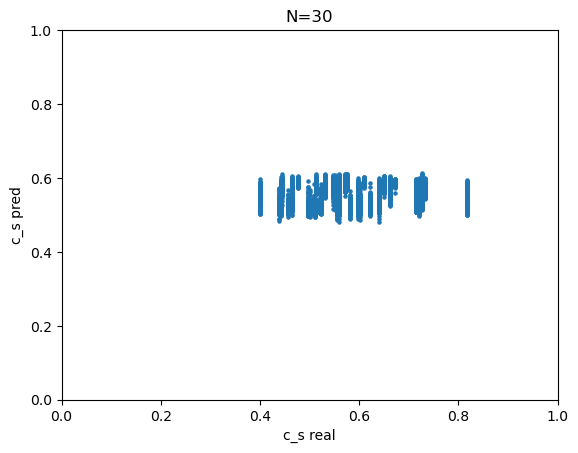

In [19]:
#First analysis, check what is the mean of the speed of sound
stat_test = np.empty([len(y_test), 2]) #mean, std dv
stat_hat = np.empty([len(y_hat), 2]) #mean, std dv
for i in range(0,len(y_test)):
    #Note for the real data, interval of 10 lines are the same EOS with different shift
    stat_test[i] = [statistics.mean(y_test[i,8:15]),statistics.pstdev(y_test[i,8:15])]
    stat_hat[i] = [statistics.mean(y_hat[i,8:15]),statistics.pstdev(y_hat[i,8:15])]

plot_mean_cs(stat_test, stat_hat, points, save = False)

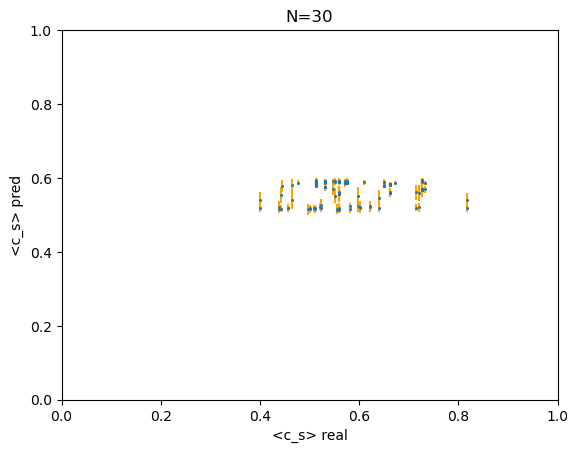

In [20]:
#Second analysis: it's the same eos at steps of 10 rows, I average over this 10 rows
#disadvantage: each c_s interpolation is actually repeated more than 10 times, it can appear
#with different values of Λ

data_test = np.empty([int(len(stat_test)/rep_test), 2])
data_hat = np.empty([int(len(stat_test)/rep_test), 2])

produce_mean_cs_separate(data_test, data_hat, stat_test, stat_hat, rep_test)

plot_mean_cs_separate(data_test, data_hat, points, save = False)

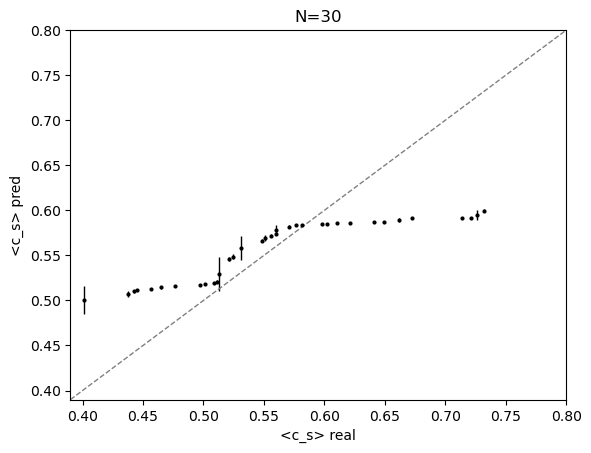

In [21]:
#Third analysis: join data for same c_s interpolation

#join test and hat, to then reorder them and not loose correspondence
data_join = np.empty([len(stat_test), 4])
for i in range(0,len(stat_test)):
    data_join[i] = [stat_test[i,0],stat_test[i,1],stat_hat[i,0],stat_hat[i,1]]

#reorder to regroup
data_join = np.sort(data_join, axis=0)

#save indices where new realisation begins
indices = []
for i in range(0,len(data_join)-1):
    if data_join[i,0] != data_join[i+1,0]:
        indices.append(i)
        
#need to include last index as well
indices.append(len(data_join)-1)

data_test = np.empty([len(indices), 2])
data_hat = np.empty([len(indices), 2])

produce_mean_cs_overall(indices, data_join, data_test, data_hat)

plot_mean_cs_overall(data_test, data_hat, points, save = False)

#### Study of speed of sound profile

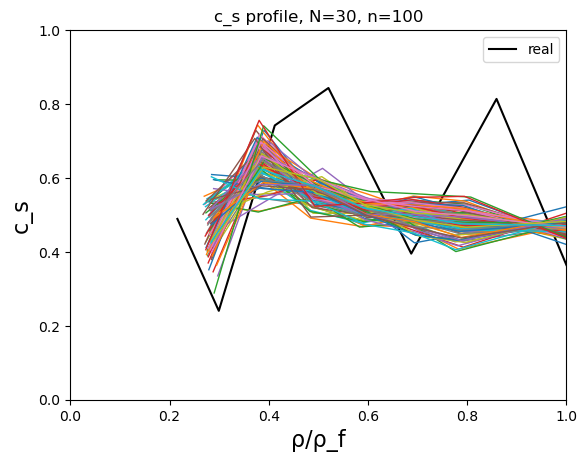

In [22]:
j = 0 #choose starting point either every 10 or every 100
plot_cs_profile(j, y_test, y_hat, rep_test, points, save = False)

#### Save EOS for TOV

In [22]:
j = 1210 #choose which EOS to save, at an interval of rep_points (10 or 100)

save_EOS(j, y_test, yeos_test, y_hat, yeos_hat, rep_test, points, save = True)